In [118]:
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
import pandas as pd
import pyreadr
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score, roc_curve
import warnings
warnings.filterwarnings("ignore")

In [119]:
result = pyreadr.read_r('gene_exp.rds')
gene_exp = result[None]
result = pyreadr.read_r('metadata_patient.rds') 
tpm = result[None]
result = pyreadr.read_r('gc3.rds') 
gc3 = result[None]
result = pyreadr.read_r('tpm_negative_mean.rds') 
tpm_negative_mean = result[None]
result = pyreadr.read_r('tpm_negative_sd.rds') 
tpm_negative_sd = result[None]


In [120]:
# Filter out the tpm DataFrame to only include rows with "Negative" diagnosis and remove Negative samples in gene_exp
negative_samples = tpm[tpm['diagnosis'] == 'Negative']
negative_sample_ids = negative_samples['sample.id'].values
gene_exp_filtered = gene_exp.drop(columns=negative_sample_ids)

In [121]:
gene_exp_filtered

,SS1147,SS3,SS2,SS556,SS2454,SS2527,SS648,SS768,SS760,SS2141,...,SS1127,SS2275,SS1309,SS2272,SS2481,SS481,SS784,SS2058,SS2670,SS2736
rownames,,,,,,,,,,,,,,,,,,,,,
A1BG,3.499711,1.737798,3.712783,1.368876,1.136268,4.916006,0.355150,3.756799,0.710733,2.756300,...,0.400543,0.322811,0.604840,1.234489,0.900413,0.827435,0.000000,0.159411,0.437374,4.429234
A1CF,2.314559,0.260850,0.883424,0.053956,0.000000,1.400139,0.314209,0.837332,0.432144,1.049849,...,0.007493,0.012318,0.026188,0.000000,0.051133,0.220115,0.046409,0.005388,0.234788,2.362706
A2M,3.208745,3.007676,4.451288,2.791521,1.142212,3.601245,1.431662,3.390437,3.371342,2.535201,...,1.567140,1.501047,1.857219,2.761287,3.493492,1.397095,2.437518,0.803616,1.647747,3.790748
A2ML1,3.924759,2.256057,3.498321,0.609148,4.520664,4.534236,1.072917,3.958673,2.260486,4.083802,...,0.676699,0.325190,0.692790,0.820089,0.561970,0.369026,0.633656,0.286880,0.555204,4.617183
A3GALT2,2.241013,0.433185,0.784553,0.000000,0.000000,2.027664,0.240165,0.887501,0.206988,0.000000,...,0.220149,0.125275,0.000000,0.000000,0.165966,0.000000,0.000000,0.000000,0.292341,1.776016
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZYG11A,1.923142,0.117253,1.844261,0.045640,0.299581,3.126989,0.264532,1.845887,0.439022,1.471453,...,0.077435,0.062878,0.146762,0.526955,0.481618,0.065601,0.283565,0.073214,0.200860,2.216669
ZYG11B,2.452650,1.916519,2.152430,1.397547,0.469135,2.648532,1.316839,2.032662,1.371245,1.652496,...,1.721533,1.127323,1.612864,1.472898,2.083928,1.227505,1.484872,0.725509,1.112920,2.449593
ZYX,3.921964,4.317996,5.216291,3.467836,4.895333,3.190650,3.146392,5.248971,4.785697,3.260545,...,2.543599,2.526321,3.036515,3.081768,3.050147,2.605002,3.551460,1.601158,0.839905,4.739553


In [122]:
gene_exp = (gene_exp_filtered - np.array(tpm_negative_mean))/np.array(tpm_negative_sd)
common_rows = gene_exp.index.intersection(gc3.iloc[:, 0])
gene_exp_filtered = gene_exp.loc[common_rows]
merged = tpm.merge(gene_exp_filtered.T, left_on='sample.id', right_index=True)
merged.iloc[:,12:]

,A1BG,A1CF,A2M,A2ML1,A3GALT2,A4GALT,A4GNT,AAAS,AACS,AADAC,...,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3
0,1.450719,1.702800,0.717229,1.271472,2.777080,1.656282,1.218302,0.003998,1.033801,0.380602,...,1.169489,1.358211,0.688699,-0.302551,0.161345,1.582651,1.227561,0.540122,0.606232,1.111306
1,0.207502,-0.397435,0.560772,0.161211,0.011949,1.453636,-0.478348,0.817425,-0.019580,-0.946438,...,0.233324,1.210290,1.347378,3.423805,1.510810,-0.586525,0.425164,0.871184,0.817441,0.087203
2,1.601065,0.239244,1.684083,0.987744,0.549379,1.481323,1.149925,0.276555,1.673300,1.701785,...,1.873794,-0.168500,-0.686857,-0.186673,0.547241,1.487902,0.778239,1.622111,1.235533,0.138877
3,-0.052812,-0.609016,0.392575,-0.934550,-0.650621,-0.405067,-0.274876,-0.158261,-0.567448,-0.946438,...,-0.166110,-0.316168,-0.924854,-0.505556,-1.043143,-0.672544,-0.351551,0.160496,-1.254484,-0.294318
4,-0.216942,-0.664194,-0.890794,1.667954,-0.650621,-0.978115,-0.478348,-1.434541,0.054266,-0.946438,...,0.169679,-0.421875,-1.510541,-0.789809,-1.106633,-0.367518,-1.741052,1.353807,-0.999986,-1.643802
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
373,-0.434856,-0.439092,-0.692463,-1.094313,-0.650621,0.718249,-0.478348,0.058380,-0.642560,-0.946438,...,-0.483690,-0.418501,0.290934,-0.305188,-0.040411,-0.648568,-0.606043,-0.560787,-1.059473,-0.603792
377,-1.018700,-0.616734,0.117117,-0.918243,-0.650621,0.442515,-0.478348,0.678703,-0.545170,-0.541719,...,-0.498879,-0.339490,0.327242,-0.505531,0.081326,-0.386756,-0.220857,0.230401,0.060965,-0.224487
379,-0.906218,-0.658684,-1.154265,-1.148969,-0.650621,-0.983881,-0.417562,-1.515259,-1.298143,-0.758944,...,-1.126193,-0.682364,-1.116799,-1.200821,-1.589243,-0.639423,-1.357352,-1.399946,-1.756463,-1.152967
380,-0.710086,-0.424087,-0.497424,-0.970441,-0.203475,-0.712687,-0.478348,0.024687,-0.760290,-0.662071,...,-0.230118,-1.054774,-0.416912,-0.544980,-0.501034,-0.486099,-0.777536,-2.036313,-0.604012,-0.582090


In [123]:
selected_columns = merged.iloc[:, 12:]
abs_values = selected_columns.abs()
average_abs_values = abs_values.mean()
ranked_average_abs_values = average_abs_values.sort_values(ascending=False)

In [140]:
ranked_average_abs_values.iloc[3:,]

ADM         1.153716
C1QC        1.134224
MAFF        1.098387
C1QA        1.068627
UGT2A2      1.066048
              ...   
USP17L22    0.194121
USP17L15    0.183180
GAGE12G     0.142629
USP17L21    0.138973
INS-IGF2    0.137494
Length: 19111, dtype: float64

In [128]:
merged[ranked_average_abs_values.index[3:5]]

,ADM,C1QC
0,0.276546,2.626250
1,1.215570,1.756729
2,0.985007,1.653370
3,-0.246479,2.719658
4,1.228187,-0.229330
...,...,...
373,-1.196104,0.137673
377,-0.647395,2.169365
379,-2.592502,-0.568311
380,-2.351359,-0.596347


In [125]:
best_model = [None]*20
accuracy = [None]*20
auroc = [None]*20

for i in range(20):
    X = merged[ranked_average_abs_values.index[3:4+i]].values
    y = merged['diagnosis'].values
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)
    print(X.shape)
    params = {'hidden_layer_sizes': [(10,), (15,), (20,)],
              'alpha': [1e-4, 1e-5, 1e-6],
              'solver': ['sgd', 'adam'],
              'random_state': [123]}
    model = MLPClassifier()

    # Use GridSearchCV for hyperparameter tuning with 5-fold cross validation
    grid_search = GridSearchCV(model, param_grid=params, cv=5)

    # Fit the grid search model to the training data
    grid_search.fit(X_train, y_train)

    # Print the best hyperparameters and corresponding accuracy score
    print("Best parameters: ", grid_search.best_params_)
    print("Best accuracy: ", grid_search.best_score_)

    # Get the best model and predict on the test data
    best_model[i] = grid_search.best_estimator_
    pred = best_model[i].predict(X_test)
    accuracy[i] = accuracy_score(y_test, pred)
    print("Test accuracy: ", accuracy[i])
    pred_probs = best_model[i].predict_proba(X_test)
    # Calculate the AUROC score, expected over 70%
    auroc[i] = roc_auc_score(y_test, pred_probs[:, 1])
    print("AUROC: ", auroc[i])
# i = 8,13,14,19,20

(247, 1)
Best parameters:  {'alpha': 0.0001, 'hidden_layer_sizes': (10,), 'random_state': 123, 'solver': 'sgd'}
Best accuracy:  0.6903846153846155
Test accuracy:  0.76
AUROC:  0.4451754385964912
(247, 2)
Best parameters:  {'alpha': 0.0001, 'hidden_layer_sizes': (10,), 'random_state': 123, 'solver': 'sgd'}
Best accuracy:  0.6903846153846155
Test accuracy:  0.76
AUROC:  0.5241228070175439
(247, 3)
Best parameters:  {'alpha': 0.0001, 'hidden_layer_sizes': (10,), 'random_state': 123, 'solver': 'adam'}
Best accuracy:  0.7156410256410257
Test accuracy:  0.76
AUROC:  0.7149122807017544
(247, 4)
Best parameters:  {'alpha': 0.0001, 'hidden_layer_sizes': (20,), 'random_state': 123, 'solver': 'sgd'}
Best accuracy:  0.6905128205128206
Test accuracy:  0.76
AUROC:  0.6535087719298246
(247, 5)
Best parameters:  {'alpha': 0.0001, 'hidden_layer_sizes': (10,), 'random_state': 123, 'solver': 'sgd'}
Best accuracy:  0.7206410256410256
Test accuracy:  0.64
AUROC:  0.6929824561403508
(247, 6)
Best parameters

In [12]:
# Age included as the first feature

_best_model = [None]*20
_accuracy = [None]*20
_auroc = [None]*20

for i in range(20):
    X = merged[ranked_average_abs_values.index[3:4+i]].values
    y = merged['diagnosis'].values
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)
    print(X.shape)
    params = {'hidden_layer_sizes': [(10,), (15,), (20,)],
              'alpha': [1e-4, 1e-5, 1e-6],
              'solver': ['sgd', 'adam'],
              'random_state': [123]}
    model = MLPClassifier()

    # Use GridSearchCV for hyperparameter tuning with 5-fold cross validation
    grid_search = GridSearchCV(model, param_grid=params, cv=5)

    # Fit the grid search model to the training data
    grid_search.fit(X_train, y_train)

    # Print the best hyperparameters and corresponding accuracy score
    print("Best parameters: ", grid_search.best_params_)
    print("Best accuracy: ", grid_search.best_score_)

    # Get the best model and predict on the test data
    best_model[i] = grid_search.best_estimator_
    pred = best_model[i].predict(X_test)
    accuracy[i] = accuracy_score(y_test, pred)
    print("Test accuracy: ", accuracy[i])
    pred_probs = best_model[i].predict_proba(X_test)
    # Calculate the AUROC score, expected over 70%
    auroc[i] = roc_auc_score(y_test, pred_probs[:, 1])
    print("AUROC: ", auroc[i])
# i = 8,13,14,19,20

Best parameters:  {'alpha': 0.0001, 'hidden_layer_sizes': (20,), 'random_state': 123, 'solver': 'sgd'}
Best accuracy:  0.7657692307692308
Test accuracy:  0.8
AUROC:  0.8771929824561403


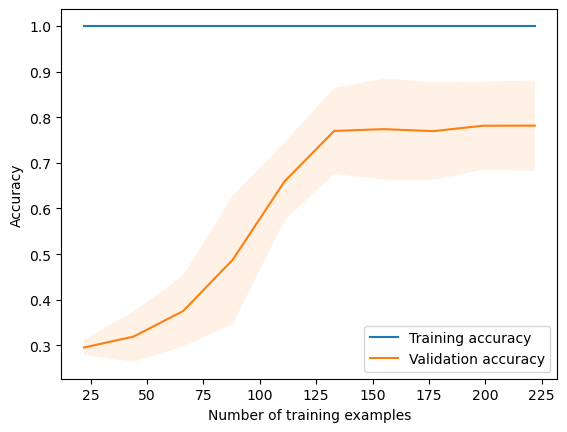

In [13]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt

train_sizes, train_scores, test_scores = learning_curve(
    best_model, X, y, cv=10, train_sizes=np.linspace(0.1, 1.0, 10), scoring='accuracy')

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean, label='Training accuracy')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1)
plt.plot(train_sizes, test_mean, label='Validation accuracy')
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1)
plt.xlabel('Number of training examples')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.show()

In [16]:
encoded_diagnosis_array = np.where(y_test == 'Mild', 0, 1)

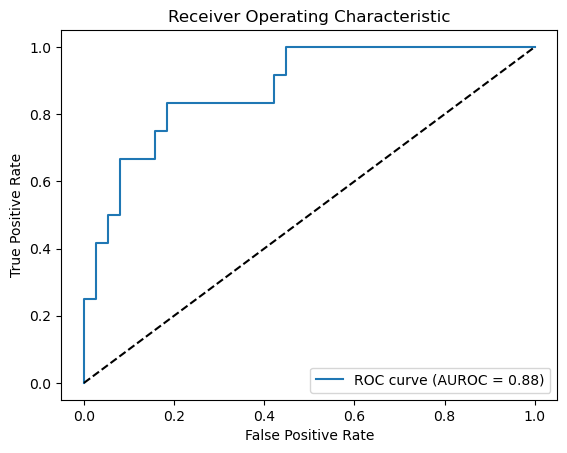

In [17]:
# Calculate the ROC curve
fpr, tpr, _ = roc_curve(encoded_diagnosis_array, pred_probs[:, 1])

# Plot the ROC curve
plt.plot(fpr, tpr, label='ROC curve (AUROC = %0.2f)' % auroc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()
